Loading the required libraries.

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm



c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reading the input files obtained from different sources.

In [2]:
df = pd.read_excel("..\\Datasets\\finaldata.xlsx")

In [3]:
df.shape

(30620, 21)

In [4]:
df.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,temp,rhum,msl,wdsp,wddir,ElectricityPrice,day,month,hour,weekday
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,8.8,80,1034.7,9,250,70.28,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,8.3,82,1034.7,9,250,65.18,1,1,1,1


In [5]:
df.drop_duplicates(subset=['TimeStamp'])

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,temp,rhum,msl,wdsp,wddir,ElectricityPrice,day,month,hour,weekday
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,8.8,80,1034.7,9,250,70.28,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,8.3,82,1034.7,9,250,65.18,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,8.4,82,1034.7,8,240,60.91,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,...,8.6,82,1035.2,8,250,65.16,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,...,8.4,85,1035.5,10,250,65.16,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,377.75,367.16,0.0931,116.3,456.0,146.4,96.5,...,15.8,73,1008.3,6,80,330.00,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,320.79,311.32,0.0751,92.3,450.7,123.8,93.6,...,14.5,80,1008.5,5,100,289.00,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,299.52,290.98,0.0668,80.5,450.7,122.2,93.6,...,14.0,77,1008.8,3,250,228.59,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,318.77,309.83,0.0732,59.7,340.1,121.5,96.1,...,13.3,82,1008.9,6,270,228.59,29,6,22,2


In [6]:
data=df.copy()

In [7]:
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('TimeStamp')
data = data.asfreq('H')
data = data.sort_index()
data.head(2)

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,msl,wdsp,wddir,ElectricityPrice,day,month,hour,weekday
TimeStamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,1034.7,9.0,250.0,70.28,1.0,1.0,0.0,1.0
2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,1034.7,9.0,250.0,65.18,1.0,1.0,1.0,1.0


In [8]:
data=data.fillna(method='ffill')

In [9]:
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [10]:
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)

In [11]:

min_date = data.index.min()
max_date = data.index.max()
print("Min:", min_date, "Max:", max_date)

Min: 2019-01-01 00:00:00 Max: 2022-06-29 23:00:00


In [12]:

train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff


Timestamp('2021-10-17 18:24:00', freq='H')

In [13]:

days_between = time_between / np.timedelta64(1, 'D')
days_between

1275.9583333333333

In [14]:

train_days = 1260
train_cutoff = min_date + pd.DateOffset(train_days)

In [15]:
train_df = data[data.index <= train_cutoff]
test_df = data[data.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))


Train: 2019-01-01 00:00:00 2022-06-14 00:00:00 30241
Test: 2022-06-14 01:00:00 2022-06-29 23:00:00 383


In [16]:
param = (0, 1, 1)
param_seasonal = (0, 1, 1, 12) 

In [18]:
mod = sm.tsa.statespace.SARIMAX(
                train_df['ElectricityPrice'],
                exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'],
                order=(0, 1, 1),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = mod.fit()

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


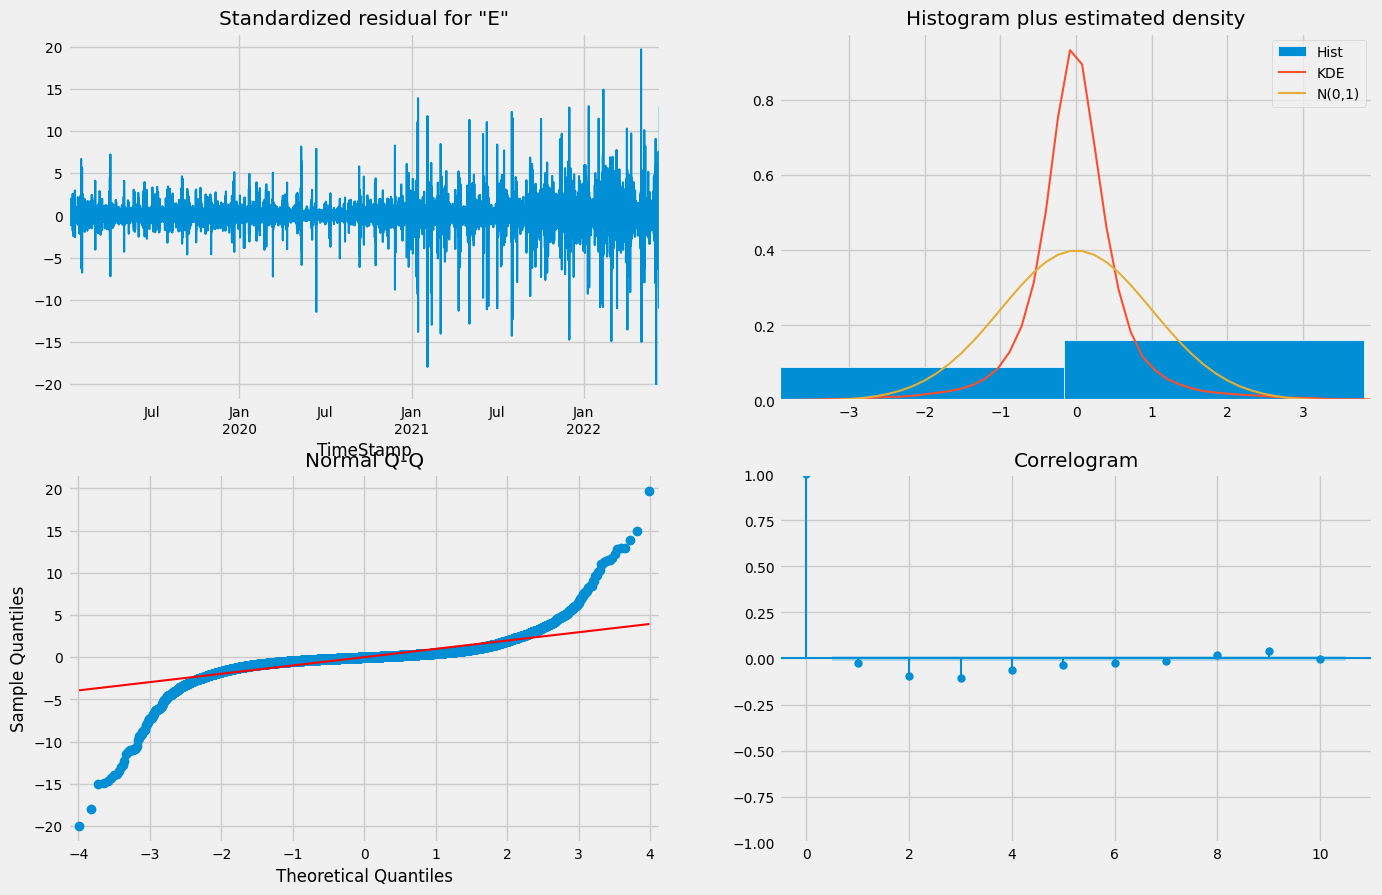

In [19]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [20]:
pred = results.get_forecast(steps=len(test_df),exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

In [21]:
pred_ci = pred.conf_int()

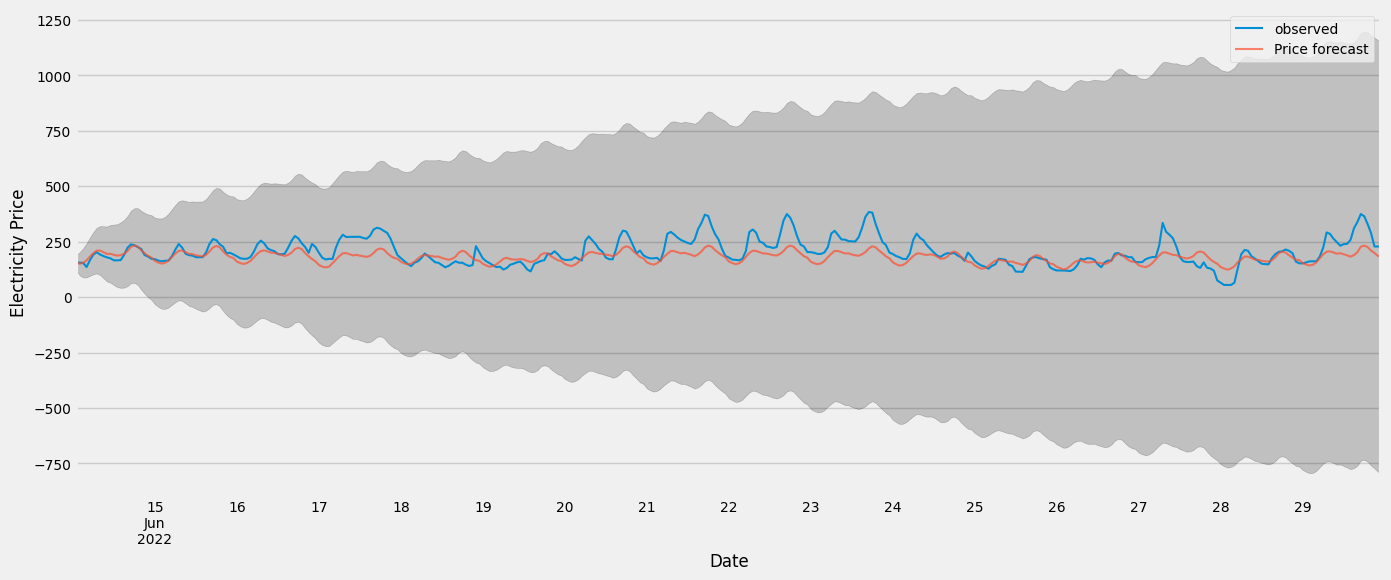

In [22]:
ax = test_df['ElectricityPrice'].plot(label='observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='Price forecast', alpha=0.7)

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Electricity Price')
plt.legend()
plt.show()

In [23]:
y_forecasted = pred.predicted_mean
y_truth = test_df['ElectricityPrice']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2465.77


In [24]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = HistGradientBoostingRegressor(),
                lags      = 10,
                transformer_y    = StandardScaler(),
                transformer_exog = None
             )

forecaster.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'])
forecaster

ForecasterAutoreg 
Regressor: HistGradientBoostingRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Demand', 'IE Wind Availability', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'msl', 'wdsp', 'wddir', 'day', 'month', 'hour', 'weekday'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2022-06-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst'

In [25]:
steps = len(test_df)

In [26]:
predictions = forecaster.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

In [34]:
forecaster.get_feature_importance()

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\ForecasterAutoreg\ForecasterAutoreg.py:1295: UserWarning: get_feature_importance() method has been renamed to get_feature_importances(). This method will be removed in skforecast 0.9.0.
  warnings.warn(
c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\ForecasterAutoreg\ForecasterAutoreg.py:1257: UserWarning: Impossible to access feature importances for regressor of type <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>. This method is only valid when the regressor stores internally the feature importances in the attribute `feature_importances_` or `coef_`.
  warnings.warn(


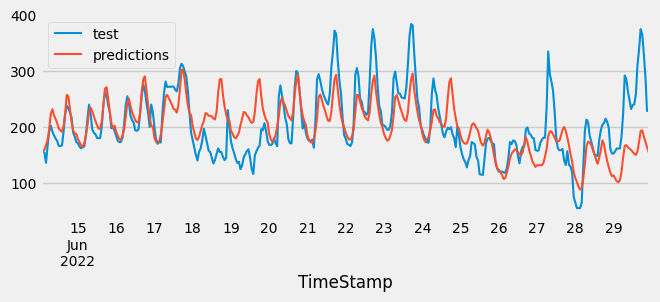

In [27]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
test_df['ElectricityPrice'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [41]:

# Backtest train data
# ==============================================================================
metric, predictions_train = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = train_df['ElectricityPrice'],
                                exog= train_df.loc[:, train_df.columns != 'ElectricityPrice'],
                                initial_train_size = None,
                                steps      = 1,
                                metric     = 'mean_squared_error',
                                refit      = False,
                                verbose    = False
                           )

print(f"Backtest error: {metric}")

100%|██████████| 30231/30231 [03:06<00:00, 161.80it/s]


Backtest error: 137.61872827133917


The first 10 observations are not predicted because it is not possible to create the lags matrix


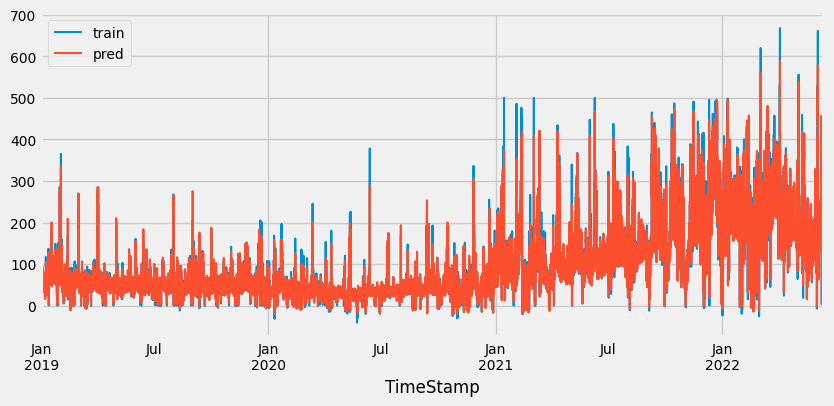

In [42]:
# Plot training predictions
# ==============================================================================
n_lags = max(forecaster.lags)

print(f"The first {n_lags} observations are not predicted because "\
      "it is not possible to create the lags matrix")

fig, ax = plt.subplots(figsize=(9, 4))
train_df['ElectricityPrice'].plot(ax=ax, label='train')
predictions_train.plot(ax=ax, label='predictions')
ax.legend();

In [31]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test_df['ElectricityPrice'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 2284.4418602849537


In [29]:
# Prediction intervals
# ==============================================================================
predictions2 = forecaster.predict_interval(
                    steps    = steps,
                    exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'],
                    interval = [5, 95],
                    n_boot   = 500
              )

predictions2.head(4)

,pred,lower_bound,upper_bound
2022-06-14 01:00:00,160.157747,144.567489,176.205707
2022-06-14 02:00:00,158.090016,134.843901,187.417375
2022-06-14 03:00:00,159.257637,126.794976,194.951903
2022-06-14 04:00:00,167.363234,122.903490,213.620312


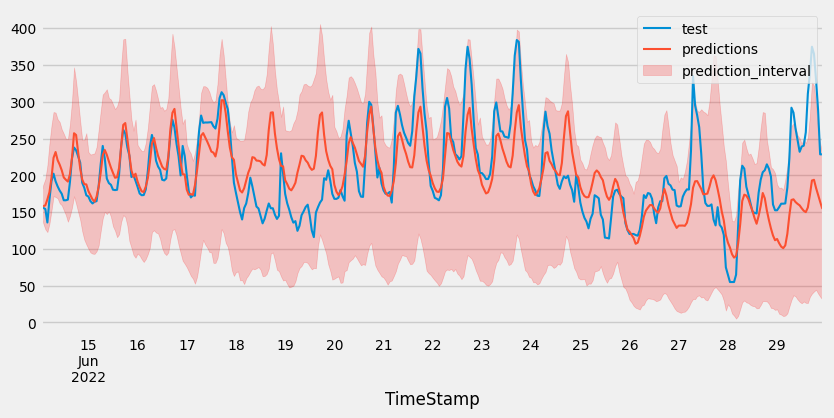

In [30]:
# Plot predictions and interval
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
test_df['ElectricityPrice'].plot(ax=ax, label='test')
predictions2['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions2.index,
    predictions2['lower_bound'],
    predictions2['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction_interval'
)
ax.legend(loc='upper right');

In [35]:
# Save model
save_forecaster(forecaster, file_name='hgbr.py', verbose=False)

In [ ]:
# Load model
forecaster_loaded = load_forecaster('forecaster.py')


In [ ]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Placeholder, the value will be overwritten
             )


In [49]:
# Grid search hyperparameter and lags
# ==============================================================================

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y          = train_df['ElectricityPrice'],
                        exog= train_df.loc[:, train_df.columns != 'ElectricityPrice'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 12,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(train_df),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]


ValueError: Invalid parameter 'n_estimators' for estimator HistGradientBoostingRegressor(max_depth=5). Valid parameters are: ['categorical_features', 'early_stopping', 'l2_regularization', 'learning_rate', 'loss', 'max_bins', 'max_depth', 'max_iter', 'max_leaf_nodes', 'min_samples_leaf', 'monotonic_cst', 'n_iter_no_change', 'quantile', 'random_state', 'scoring', 'tol', 'validation_fraction', 'verbose', 'warm_start'].